## 🚖 택시 요금 예측 🚖

작성자: 유재순  
작성일: 2026.02.05.목요일  

### 분석 로드맵

### 1️⃣ 시각화 기본 셋팅 진행

In [48]:
# ================
# 1. 시각화 기본 세팅 
# ================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# ================
# 1) seaborn 테마
# ================
sns.set_theme(style="whitegrid", context="notebook")

# ================
# 2) 색상 팔레트
# ================
PALETTE = "viridis"
sns.set_palette(PALETTE)

# ================
# 3) 맥 한글 폰트 설정 
# ================
from matplotlib import rcParams
rcParams["font.family"] = "AppleGothic"

# 마이너스(-) 기호 깨짐 방지
rcParams["axes.unicode_minus"] = False

# 해상도 기본값
rcParams["figure.dpi"] = 120
rcParams["savefig.dpi"] = 300

# matplotlib 기본 스타일 통일
plt.rcParams["axes.grid"] = True  # 그리드 켜기(whitegrid와 톤 맞춤)

print("시각화 세팅 완료")

시각화 세팅 완료


### 2️⃣ 데이터 로드 및 기본 구조

In [49]:
# ================
# 2. 데이터 로드 및 기본 구조
# ================

from IPython.display import display

# 데이터 로드
df = pd.read_csv("trip.csv")

# ----------------
# 2-1) 데이터 크기 요약
# ----------------
n_rows, n_cols = df.shape
print(f"데이터 크기: {n_rows:,}행 x {n_cols:,}열")

# ----------------
# 2-2) 변수(컬럼) 개수/이름 요약
# ----------------
print(f"변수(컬럼) 개수: {len(df.columns)}개")
print("컬럼 이름:", ", ".join(df.columns))

# ----------------
# 2-3) 수치형 / 범주형 변수 요약
# ----------------
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns


print(f"수치형 변수 개수: {len(num_cols)}개")
print("수치형 변수:", ", ".join(num_cols))

print(f"범주형 변수 개수: {len(cat_cols)}개")
print("범주형 변수:", ", ".join(cat_cols))


데이터 크기: 22,701행 x 9열
변수(컬럼) 개수: 9개
컬럼 이름: passenger_name, tpep_pickup_datetime, tpep_dropoff_datetime, payment_method, passenger_count, trip_distance, fare_amount, tip_amount, tolls_amount
수치형 변수 개수: 5개
수치형 변수: passenger_count, trip_distance, fare_amount, tip_amount, tolls_amount
범주형 변수 개수: 4개
범주형 변수: passenger_name, tpep_pickup_datetime, tpep_dropoff_datetime, payment_method


### 3️⃣ 변수(컬럼) 설명 표 작성

In [50]:
# ================
# 3. 변수(컬럼) 한글 번역 + 설명 테이블 만들기 (결측치 정보 제외)
#    + 테이블 스타일: 컬럼(헤더) 센터, 내용(셀) 좌측 정렬
# ================

from IPython.display import display

# 1) 컬럼명(영어) -> 한글명 매핑(사전: dict)
col_ko = {
    "passenger_name": "승객_이름",
    "tpep_pickup_datetime": "승차_일시",
    "tpep_dropoff_datetime": "하차_일시",
    "payment_method": "결제_수단",
    "passenger_count": "승객_수",
    "trip_distance": "이동_거리",
    "fare_amount": "요금",
    "tip_amount": "팁",
    "tolls_amount": "통행료"
}

# 2) 변수 설명(사전: dict)
col_desc = {
    "passenger_name": "승객을 식별하는 이름(문자열). 분석에 직접 필요 없으면 익명화/제외 고려.",
    "tpep_pickup_datetime": "승차 시각(현재는 문자열). 시간 분석을 위해 datetime으로 변환 필요.",
    "tpep_dropoff_datetime": "하차 시각(현재는 문자열). 승차 시각과 함께 소요시간 계산에 사용.",
    "payment_method": "결제 방식(범주형). 결제 수단별 요금/팁 차이 분석 가능.",
    "passenger_count": "탑승 인원 수(정수). 0 또는 비정상 값은 이상치 가능성.",
    "trip_distance": "이동 거리(실수). 0 또는 과도하게 큰 값은 이상치 검토 대상.",
    "fare_amount": "기본 요금(실수). 결측치가 있으면 대체/삭제 등 처리 필요.",
    "tip_amount": "팁 금액(실수). 0이 많을 수 있으며 결제수단/요금과 연관 분석 가능.",
    "tolls_amount": "통행료 금액(실수). 특정 경로/지역 특성 반영 가능."
}

# 3) 테이블 생성 (영어/한글/타입/설명)
var_table = pd.DataFrame({
    "컬럼명(영어)": df.columns,
    "컬럼명(한글)": [col_ko.get(c, c) for c in df.columns],
    "dtype": df.dtypes.astype(str).values,
    "설명": [col_desc.get(c, "") for c in df.columns]
})

# 4) 테이블 스타일 적용: 헤더 가운데, 내용 왼쪽
styled_var_table = (
    var_table.style
    .set_properties(**{"text-align": "left"})  # 내용(셀) 좌측 정렬
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}  # 헤더(컬럼명) 가운데 정렬
    ])
)

display(styled_var_table)


,컬럼명(영어),컬럼명(한글),dtype,설명
0,passenger_name,승객_이름,object,승객을 식별하는 이름(문자열). 분석에 직접 필요 없으면 익명화/제외 고려.
1,tpep_pickup_datetime,승차_일시,object,승차 시각(현재는 문자열). 시간 분석을 위해 datetime으로 변환 필요.
2,tpep_dropoff_datetime,하차_일시,object,하차 시각(현재는 문자열). 승차 시각과 함께 소요시간 계산에 사용.
3,payment_method,결제_수단,object,결제 방식(범주형). 결제 수단별 요금/팁 차이 분석 가능.
4,passenger_count,승객_수,int64,탑승 인원 수(정수). 0 또는 비정상 값은 이상치 가능성.
5,trip_distance,이동_거리,float64,이동 거리(실수). 0 또는 과도하게 큰 값은 이상치 검토 대상.
6,fare_amount,요금,float64,기본 요금(실수). 결측치가 있으면 대체/삭제 등 처리 필요.
7,tip_amount,팁,float64,팁 금액(실수). 0이 많을 수 있으며 결제수단/요금과 연관 분석 가능.
8,tolls_amount,통행료,float64,통행료 금액(실수). 특정 경로/지역 특성 반영 가능.


### 4️⃣ 데이터 전처리

In [51]:
# ================
# 4-1. 결측치 존재 여부 확인
# ================

missing_summary = pd.DataFrame({
    "결측치_개수": df.isnull().sum(),
    "결측치_비율(%)": (df.isnull().mean() * 100).round(2)
})

missing_summary



,결측치_개수,결측치_비율(%)
passenger_name,0,0.00
tpep_pickup_datetime,0,0.00
tpep_dropoff_datetime,0,0.00
payment_method,0,0.00
passenger_count,0,0.00
trip_distance,0,0.00
fare_amount,3,0.01
tip_amount,0,0.00
tolls_amount,0,0.00


In [52]:
# =========================
# 4-2-0. 준비: 수치형 컬럼 선택 + (필요 시) 소요시간 파생
# =========================

# (1) datetime 변환 (문자열이면 변환 필요)
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"], errors="coerce")

# (2) 소요시간(분) 파생변수 (이상치 판단에 매우 유용)
df["trip_duration_min"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60

# (3) IQR로 이상치 볼 수치형 컬럼 목록
numeric_cols = ["passenger_count", "trip_distance", "fare_amount", "tip_amount", "tolls_amount", "trip_duration_min"]


In [53]:
# =========================
# 4-2-1. 1차: IQR 이상치 "개수"만 요약
# =========================

outlier_info = {}
outlier_bounds = {}  # 각 컬럼의 하한/상한도 저장(나중에 분류에 재사용)

for col in numeric_cols:
    # 결측치는 quantile 계산에서 문제될 수 있으니, 계산용으로만 dropna
    Q1 = df[col].dropna().quantile(0.25)     # 1사분위(25%)
    Q3 = df[col].dropna().quantile(0.75)     # 3사분위(75%)
    IQR = Q3 - Q1                             # IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR                    # 하한(lower)
    upper = Q3 + 1.5 * IQR                    # 상한(upper)

    # (값 < 하한) 또는 (값 > 상한) 이면 IQR 이상치
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()

    outlier_info[col] = outlier_count
    outlier_bounds[col] = (lower, upper)

outlier_df = pd.DataFrame.from_dict(outlier_info, orient="index", columns=["outlier_count"])

print("=== IQR 이상치 개수 요약 ===")
print(outlier_df.sort_values("outlier_count", ascending=False))


=== IQR 이상치 개수 요약 ===
                   outlier_count
trip_distance               2527
passenger_count             2291
fare_amount                 2062
trip_duration_min           1228
tip_amount                  1186
tolls_amount                1174


In [54]:
# =========================
# 4-2-2. 2차: IQR 이상치 중 "오류 후보" vs "극단값 후보" 분류
# =========================

# (1) 오류 후보 규칙(최소 도메인 룰)
# - 현실적으로 불가능/강하게 의심되는 것들 위주
df["flag_error_candidate"] = (
    (df["trip_distance"] < 0) |
    (df["fare_amount"] < 0) |
    (df["tip_amount"] < 0) |
    (df["tolls_amount"] < 0) |
    (df["trip_duration_min"] <= 0) |    # 소요시간 0 이하(시간 역전/동일)
    (df["passenger_count"] <= 0)        # 승객수 0 이하
)

# (2) 컬럼별로: IQR 이상치 중에서 오류/극단값 개수 나누기
detail_rows = []

for col in numeric_cols:
    lower, upper = outlier_bounds[col]
    
    flag_iqr = (df[col] < lower) | (df[col] > upper)          # IQR 이상치
    flag_error = flag_iqr & (df["flag_error_candidate"] == True)    # IQR 이상치이면서 오류 규칙에도 걸림
    flag_extreme = flag_iqr & (df["flag_error_candidate"] == False) # IQR 이상치이지만 오류 규칙은 통과
    
    detail_rows.append({
        "col": col,
        "iqr_outlier_count": int(flag_iqr.sum()),
        "error_candidate_count": int(flag_error.sum()),
        "extreme_candidate_count": int(flag_extreme.sum())
    })

detail_df = pd.DataFrame(detail_rows).set_index("col")

print("=== IQR 이상치 중 오류 vs 극단값 분해 ===")
print(detail_df.sort_values("iqr_outlier_count", ascending=False))



=== IQR 이상치 중 오류 vs 극단값 분해 ===
                   iqr_outlier_count  error_candidate_count  \
col                                                           
trip_distance                   2527                      3   
passenger_count                 2291                      3   
fare_amount                     2062                      9   
trip_duration_min               1228                      4   
tip_amount                      1186                      2   
tolls_amount                    1174                      2   

                   extreme_candidate_count  
col                                         
trip_distance                         2524  
passenger_count                       2288  
fare_amount                           2053  
trip_duration_min                     1224  
tip_amount                            1184  
tolls_amount                          1172  


---
trip_distance: 2527개 중 오류 3개, 극단값 2524개  
fare_amount: 2062개 중 오류 9개, 극단값 2053개  
즉, “이상치” 대부분이 오류가 아니라 “극단값”이다.  

In [55]:
# =========================
# extreme 값 크기(분위수) 확인: 처리 필요성 판단
# =========================

check_cols = ["trip_distance", "trip_duration_min", "fare_amount", "tip_amount", "tolls_amount"]

for col in check_cols:
    q99 = df[col].quantile(0.99)   # 상위 99% 지점
    q995 = df[col].quantile(0.995) # 상위 99.5% 지점
    q999 = df[col].quantile(0.999) # 상위 99.9% 지점
    print(f"[{col}] q99={q99:.3f}, q99.5={q995:.3f}, q99.9={q999:.3f}")


[trip_distance] q99=18.800, q99.5=20.515, q99.9=25.557
[trip_duration_min] q99=60.050, q99.5=73.508, q99.9=1429.532
[fare_amount] q99=52.000, q99.5=57.500, q99.9=87.015
[tip_amount] q99=11.710, q99.5=13.465, q99.9=18.420
[tolls_amount] q99=5.760, q99.5=5.760, q99.9=12.500


---

- IQR 기준 이상치 중 다수는 현실적으로 발생 가능한 극단값이었으나,  
trip_duration_min의 상위 0.1% 구간에서는 분포의 비연속적 급증이 관찰되어  
데이터 오류 또는 비정상 기록 가능성이 높은 것으로 판단하였다.  

- 이에 따라 극단값은 제거하지 않고 유지하되,모델 안정성을 위해 일부 변수(trip_duration_min, fare_amount)에 대해서는 로그 변환을 적용하는 것이 합리적이다.  
- fare_amount의 고액 구간은 q99.9 기준 약 87 수준으로 현실적으로 발생 가능한 극단값이므로   오류로 제거할 대상은 아니다.다만 타깃 변수 특성상 소수의 큰 값이 모델 학습과 RMSE에 과도한 영향을 줄 수 있어, 삭제보다는 상단 캡핑으로 영향만 완화하는 처리가 필요하다.  

In [56]:
# =========================
# 시각화할 숫자형 변수 목록
# =========================

numeric_cols = [
    "trip_distance",
    "trip_duration_min",
    "fare_amount",
    "tip_amount",
    "tolls_amount",
    "passenger_count"
]


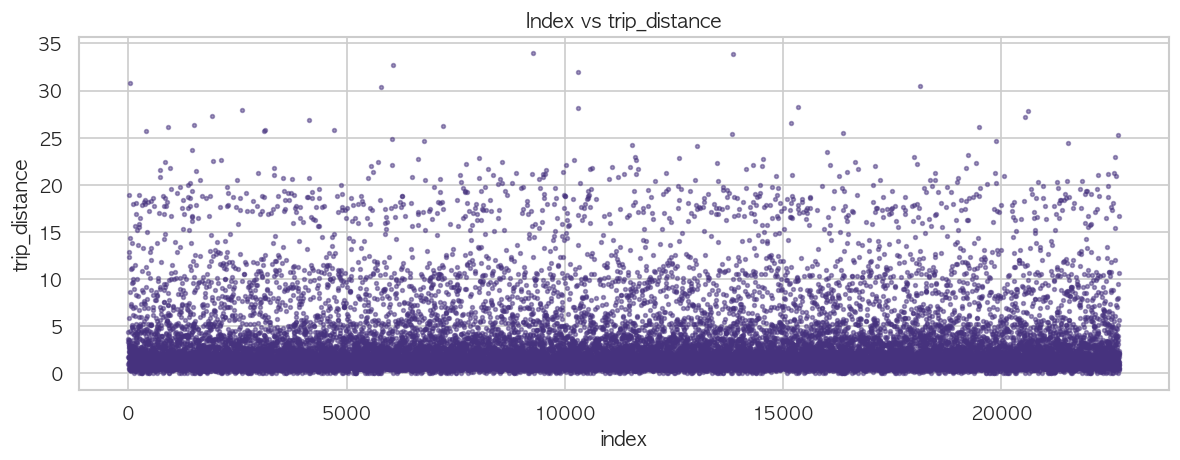

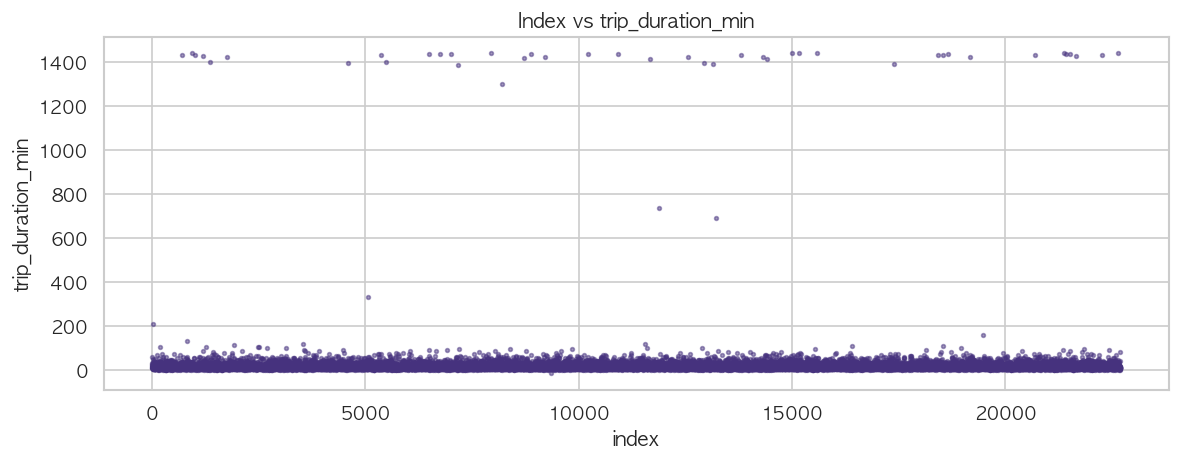

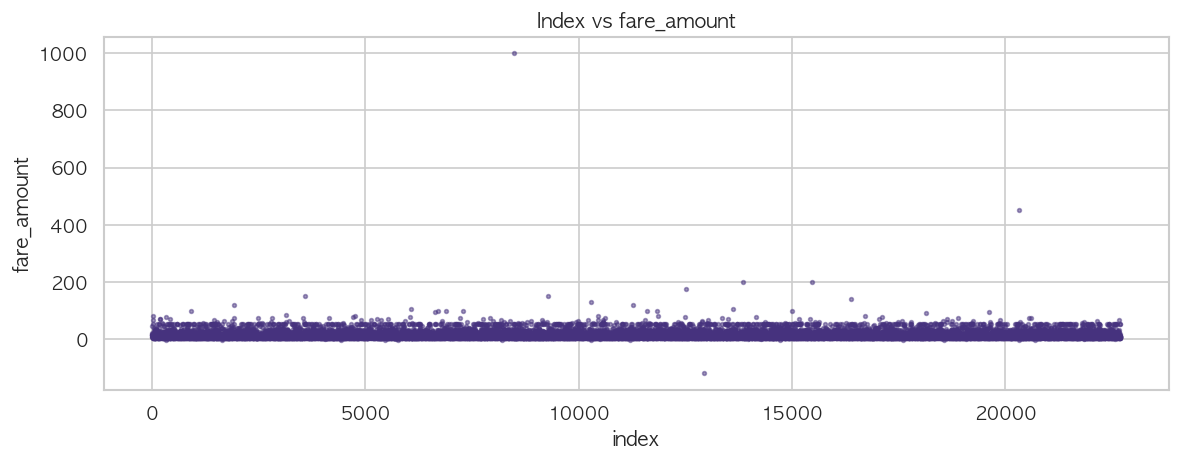

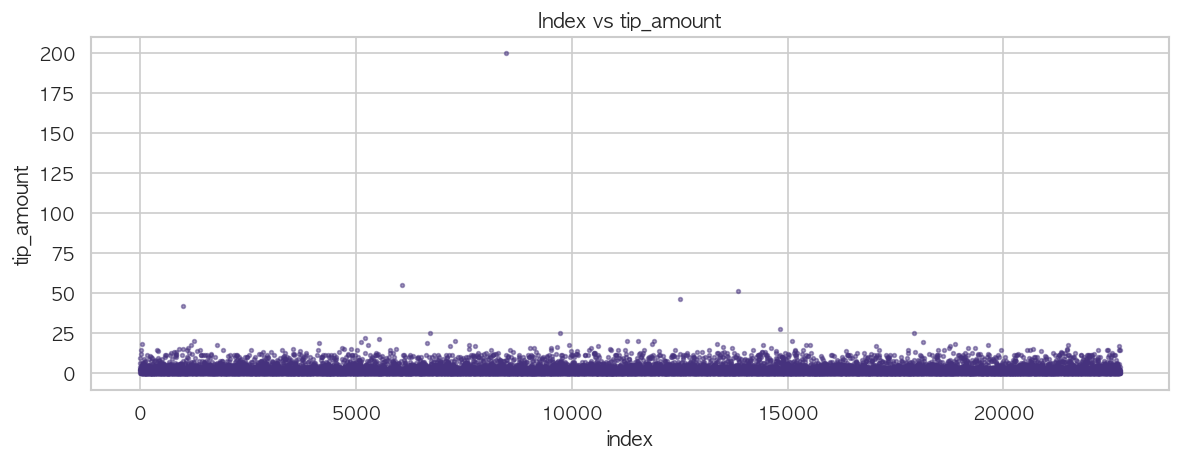

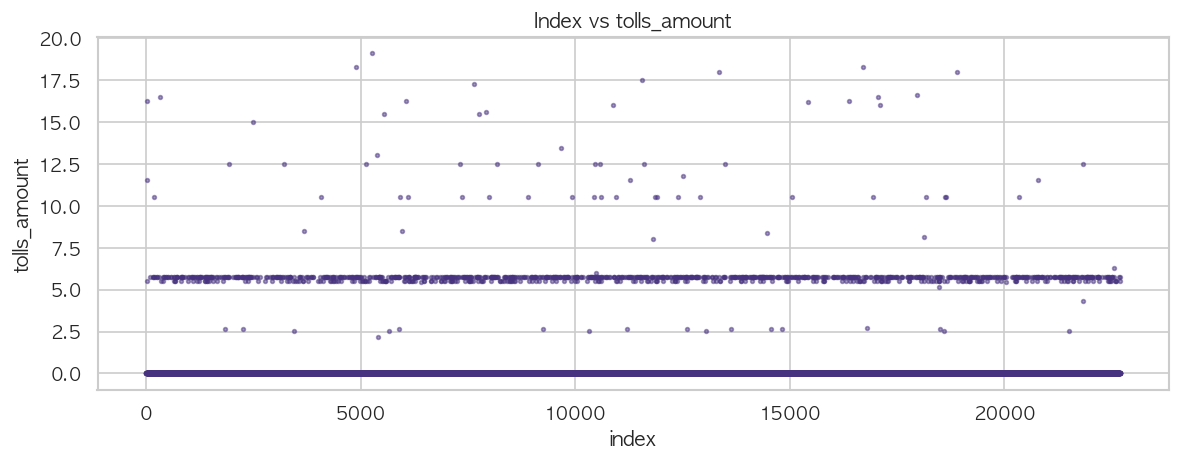

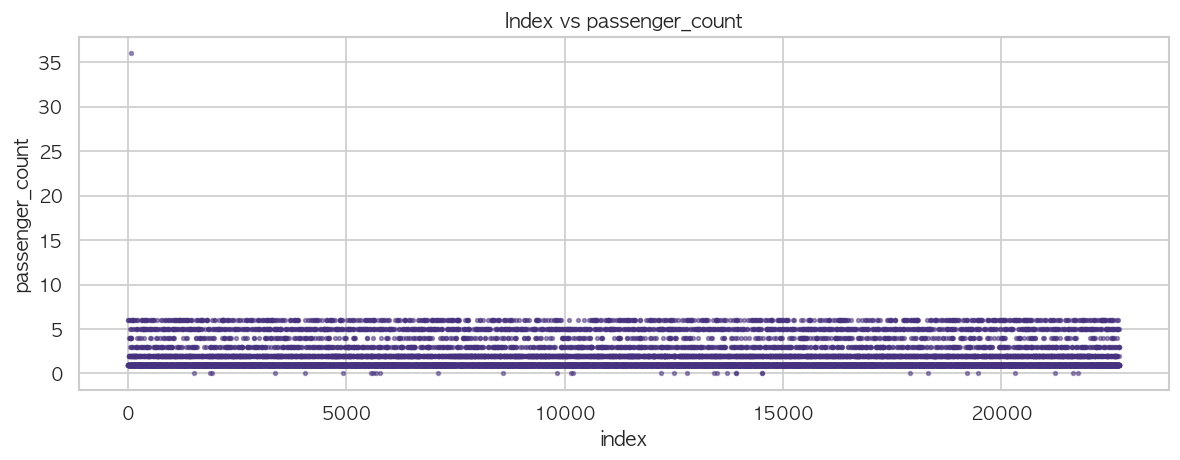

In [57]:
# =========================
# index vs value scatter plot
# =========================

import matplotlib.pyplot as plt

for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    
    # x축: 데이터 index, y축: 변수 값
    plt.scatter(df.index, df[col], s=5, alpha=0.5)
    
    plt.title(f"Index vs {col}")
    plt.xlabel("index")
    plt.ylabel(col)
    
    plt.tight_layout()
    plt.show()


In [60]:
# =========================
# 4-2. 도메인 기준으로 이상치 처리(최종 확정안)
# - passenger_count > 6 : 제거(오류)
# - trip_duration_min   : 180분 상단 캡핑(극단값 완화)
# - fare_amount         : log1p 변환(극단값 완화)
# =========================

import numpy as np
import pandas as pd

# -------------------------
# 0) 안전하게 복사본 생성 (원본 df 보존)
# -------------------------
df_clean = df.copy()

# -------------------------
# 1) passenger_count 도메인 오류 제거
#    - 일반 택시 기준 1~6명 범위를 벗어나면 오류 가능성 매우 큼
# -------------------------
before_rows = len(df_clean)

df_clean = df_clean[df_clean["passenger_count"].between(1, 6)].copy()

after_rows = len(df_clean)
print("=== passenger_count 오류 제거 ===")
print("처리 전 행 수:", before_rows)
print("처리 후 행 수:", after_rows)
print("제거된 행 수:", before_rows - after_rows)

# =========================
# (추가) trip_duration_min 하단 오류 제거 (음수 제거)
# - 소요시간은 0보다 커야 함
# - 음수/0은 시간 역전 또는 기록 오류
# =========================

before_rows = len(df_clean)
df_clean = df_clean[df_clean["trip_duration_min"] > 0].copy()
after_rows = len(df_clean)

print("\n=== trip_duration_min 음수/0 제거 ===")
print("처리 전 행 수:", before_rows)
print("처리 후 행 수:", after_rows)
print("제거된 행 수:", before_rows - after_rows)


# -------------------------
# 2) trip_duration_min 상단 캡핑(도메인 기준)
#    - 180분(3시간) 이상은 비정상 장시간(기록 오류/미종료 등) 가능성 높음
#    - 제거 대신 cap으로 영향만 완화
# -------------------------
DURATION_CAP = 180  # 도메인 상한(분)

# clip(upper=...): 상한 초과 값은 상한값으로 바꿈
df_clean["trip_duration_min_capped"] = df_clean["trip_duration_min"].clip(upper=DURATION_CAP)

print("\n=== trip_duration_min 상단 캡핑 ===")
print("캡핑 상한(분):", DURATION_CAP)
print("캡핑 전 최대값:", df_clean["trip_duration_min"].max())
print("캡핑 후 최대값:", df_clean["trip_duration_min_capped"].max())

# -------------------------
# 3) fare_amount 로그 변환(log1p)
#    - log1p(x) = log(1 + x)
#    - 0이 있어도 변환 가능
#    - 고액 구간 영향만 완화(정보는 유지)
# -------------------------
# 혹시 음수 요금이 남아있으면 로그가 깨지므로(로그는 음수 불가) 안전 처리
# 음수는 데이터 오류이므로 제거
before_rows = len(df_clean)
df_clean = df_clean[df_clean["fare_amount"] >= 0].copy()
after_rows = len(df_clean)

print("\n=== fare_amount 음수 제거(로그 변환 안전장치) ===")
print("처리 전 행 수:", before_rows)
print("처리 후 행 수:", after_rows)
print("제거된 행 수:", before_rows - after_rows)

df_clean["fare_amount_log1p"] = np.log1p(df_clean["fare_amount"])

print("\n=== fare_amount 로그 변환(log1p) ===")
print("변환 전 최대값:", df_clean["fare_amount"].max())
print("변환 후 최대값:", df_clean["fare_amount_log1p"].max())

# -------------------------
# 4) 간단 검증: 처리 전/후 핵심 통계 비교(최소)
# -------------------------
print("\n=== 처리 후 핵심 요약 통계(df_clean) ===")
display(
    df_clean[["passenger_count", "trip_duration_min", "trip_duration_min_capped", "fare_amount", "fare_amount_log1p"]]
    .describe()
    .T
)

# 참고:
# - 이후 모델링에서는 기존 컬럼 대신
#   trip_duration_min_capped, fare_amount_log1p 를 사용하는 것을 권장


=== passenger_count 오류 제거 ===
처리 전 행 수: 22701
처리 후 행 수: 22667
제거된 행 수: 34

=== trip_duration_min 음수/0 제거 ===
처리 전 행 수: 22667
처리 후 행 수: 22641
제거된 행 수: 26

=== trip_duration_min 상단 캡핑 ===
캡핑 상한(분): 180
캡핑 전 최대값: 1439.55
캡핑 후 최대값: 180.0

=== fare_amount 음수 제거(로그 변환 안전장치) ===
처리 전 행 수: 22641
처리 후 행 수: 22624
제거된 행 수: 17

=== fare_amount 로그 변환(log1p) ===
변환 전 최대값: 999.99
변환 후 최대값: 6.90874478925533

=== 처리 후 핵심 요약 통계(df_clean) ===


,count,mean,std,min,25%,50%,75%,max
passenger_count,22624.0,1.644758,1.284557,1.000000,1.000000,1.000000,2.00000,6.000000
trip_duration_min,22624.0,16.984845,61.413038,0.016667,6.683333,11.183333,18.38750,1439.550000
trip_duration_min_capped,22624.0,14.677969,13.740707,0.016667,6.683333,11.183333,18.38750,180.000000
fare_amount,22624.0,13.034075,13.197149,0.000000,6.500000,9.500000,14.50000,999.990000
fare_amount_log1p,22624.0,2.439920,0.584145,0.000000,2.014903,2.351375,2.74084,6.908745


### 5️⃣ 파생변수 생성  
속도, 단가, 팁 비율 같은 "설명력 높은' 변수 추가함

In [61]:
# =========================
# 5. 파생변수 생성 (최소 추천 세트)
# - 주의: trip_duration_min_capped를 사용(극단값 완화된 시간)
# =========================

df_feat = df_clean.copy()

# 1) 평균 속도(mph) = 거리 / (시간(시간단위))
# trip_duration_min_capped(분) → 시간(hour)로 바꾸려면 /60
df_feat["duration_hour"] = df_feat["trip_duration_min_capped"] / 60
df_feat["speed_mph"] = df_feat["trip_distance"] / df_feat["duration_hour"]

# 2) 거리당 요금(단가) = fare / distance
# 거리 0이면 나눗셈 오류가 나므로, 0은 NaN으로 처리 후 계산
df_feat["trip_distance_nonzero"] = df_feat["trip_distance"].replace(0, np.nan)
df_feat["fare_per_mile"] = df_feat["fare_amount"] / df_feat["trip_distance_nonzero"]

# 3) 팁 비율 = tip / fare
# fare 0이면 나눗셈 오류이므로 0은 NaN으로 처리
df_feat["fare_amount_nonzero"] = df_feat["fare_amount"].replace(0, np.nan)
df_feat["tip_rate"] = df_feat["tip_amount"] / df_feat["fare_amount_nonzero"]

# 4) 결측 처리(나눗셈에서 생긴 NaN을 0으로 대체하는 방식 예시)
# (모델에 따라 NaN을 그대로 두고 imputer를 쓰는게 더 나을 때도 있음)
df_feat[["speed_mph", "fare_per_mile", "tip_rate"]] = df_feat[["speed_mph", "fare_per_mile", "tip_rate"]].fillna(0)

# 확인
display(df_feat[["speed_mph", "fare_per_mile", "tip_rate"]].describe().T)


,count,mean,std,min,25%,50%,75%,max
speed_mph,22624.0,13.785260,147.020644,0.0,7.251228,9.841279,13.605393,15120.0
fare_per_mile,22624.0,7.380846,71.924906,0.0,4.303127,5.500000,7.055215,5200.0
tip_rate,22624.0,0.144157,0.139974,0.0,0.000000,0.183485,0.229091,5.6


---

거리·시간·요금 기반 파생변수는 해석력이 높지만, 분모가 작은 경우 극단값이 발생하여 도메인 기준에 따른 상단 캡핑을 적용하였다.

In [62]:
# =========================
# 파생변수 도메인 기준 상단 캡핑
# (speed_mph, fare_per_mile, tip_rate)
# =========================

df_feat_clean = df_feat.copy()

# 1) speed_mph 캡핑
SPEED_CAP = 80  # mph
df_feat_clean["speed_mph_capped"] = df_feat_clean["speed_mph"].clip(upper=SPEED_CAP)

# 2) fare_per_mile 캡핑
FARE_PER_MILE_CAP = 100
df_feat_clean["fare_per_mile_capped"] = df_feat_clean["fare_per_mile"].clip(upper=FARE_PER_MILE_CAP)

# 3) tip_rate 캡핑
TIP_RATE_CAP = 1.0
df_feat_clean["tip_rate_capped"] = df_feat_clean["tip_rate"].clip(upper=TIP_RATE_CAP)

print("=== 파생변수 캡핑 기준 ===")
print("speed_mph ≤", SPEED_CAP)
print("fare_per_mile ≤", FARE_PER_MILE_CAP)
print("tip_rate ≤", TIP_RATE_CAP)

# 간단 sanity check
display(
    df_feat_clean[
        ["speed_mph", "speed_mph_capped",
         "fare_per_mile", "fare_per_mile_capped",
         "tip_rate", "tip_rate_capped"]
    ]
    .describe()
    .T
)


=== 파생변수 캡핑 기준 ===
speed_mph ≤ 80
fare_per_mile ≤ 100
tip_rate ≤ 1.0


,count,mean,std,min,25%,50%,75%,max
speed_mph,22624.0,13.785260,147.020644,0.0,7.251228,9.841279,13.605393,15120.0
speed_mph_capped,22624.0,11.313233,6.578683,0.0,7.251228,9.841279,13.605393,80.0
fare_per_mile,22624.0,7.380846,71.924906,0.0,4.303127,5.500000,7.055215,5200.0
fare_per_mile_capped,22624.0,6.193699,4.807379,0.0,4.303127,5.500000,7.055215,100.0
tip_rate,22624.0,0.144157,0.139974,0.0,0.000000,0.183485,0.229091,5.6
tip_rate_capped,22624.0,0.143066,0.122368,0.0,0.000000,0.183485,0.229091,1.0
